In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('/content/Brain_Tumor.csv')

In [3]:
df.shape

(3762, 15)

In [4]:
df.head()

,image,tumor,mean,variance,standard_deviation,entropy,skewness,kurtosis,contrast,energy,ASM,homogeneity,dissimilarity,correlation,coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


##EDA

In [ ]:
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
#--------------------ANÁLISIS EXPLORATORIO DE DATOS----------------------------#
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#

**VARIABLES**

**First-Order Statistics:** Mean, variance, standard deviation, skewness, kurtosis.

Sea $I$ cierta variable aleatoria que representa los niveles de gris de cierta región de la imagen. Se define el histograma de primer orden $P(I)$ como

$$P(I)=\frac{nº\,de\,pixels\,con\,nivel\,de\,gris\,I}{nº\,total\,de\,pixels\,en\,la\,region}.$$

Se tendría entonces la media (Mean) y tres "momentos centrales": varianza, skewness y kurtosis. En este dataset se considera también la desviación estándar.

- **Variance y Standard Deviation:** medida de la anchura del histograma. Mide la desviación de los niveles de gris respecto de la media.
- **Skewness:** Medida del grado de asimetría del histograma con respecto de la media.
- **Kurtosis:** Medida de la pronunciación de pico que muestra el histograma.


**Second-Order Statistics:** ASM, contrast, correlation, homogeneity, entropy, dissmilarity, coarseness.

- **ASM (Angular Second Moment):** mide la suavidad de la imagen. Valore más bajos indican menor suavidad.
- **Contrast:** Medida de variaciones de nivel locales. Valores más altos indican mayor contraste.
- **Correlation:** Correlación entre pixeles en dos direcciones distintas.
- **Homogeneity:** Mayor homogeneidad indica imágenes con bajo contraste.
- **Entropy:** Mide la aleatoriedad. Valores bajos indican imágenes con mayor suavidad.
- **Dissmilarity:** No lo explica el paper pero debería ser la falta de parecido entre pixeles. Valores altos indicaría menos semejanza (supongo).
- **Energy:** ? tampoco lo explica el paper
- **Coarseness:** No sé qué indica pero siempre mantiene un valor constante de $7.458341\cdot 10^{-155}$, así que no sirve para un modelo de predicción.

Las imágenes se distinguen según sus niveles de gris con los distintos features. Se mide la configuración de niveles de gris con una matriz de frecuencias relativas $P_{d,\theta}(I_{1}, I_{2})$, que describe con qué frecuencia dos pixels con niveles de gris $I_{1}$, $I_{2}$ aparecen separadas por una distancia $d$ en la dirección $\theta$. Es decir, cómo se distribuyen las intensidades de gris en la imagen. Todas las variables se escriben en función de la matriz $P$ y las intensidades $I_{1}$, $I_{2}$.

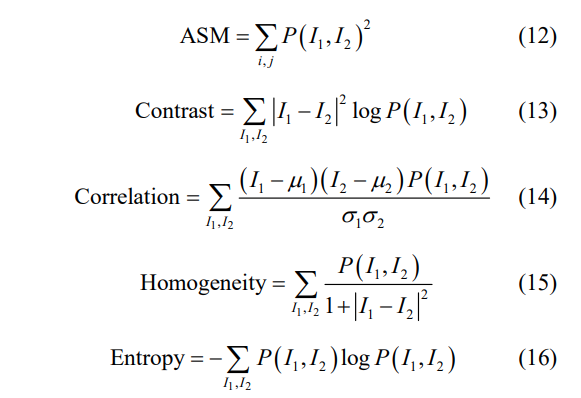

[DOI:10.4236/jsip.2012.32019](https://doi.org/10.4236/jsip.2012.32019)

In [ ]:
# Vemos cómo son las imágenes en ciertos valores extremos

In [ ]:
df[df['energy']==df.energy.max()]

,image,tumor,mean,variance,standard_deviation,entropy,skewness,kurtosis,contrast,energy,ASM,homogeneity,dissimilarity,correlation,coarseness
26,Image27,0,1.119476,66.186853,8.13553,0.394539,7.726651,61.790624,188.909201,0.589682,0.347725,0.721656,4.339588,0.891208,7.458341e-155


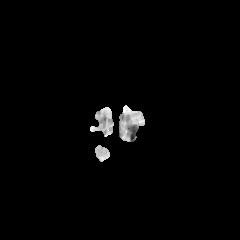

In [ ]:
df[df['energy']==df.energy.min()]

,image,tumor,mean,variance,standard_deviation,entropy,skewness,kurtosis,contrast,energy,ASM,homogeneity,dissimilarity,correlation,coarseness
1378,Image1379,1,11.267197,1099.518922,33.158995,0.000882,3.586309,13.699309,199.25883,0.024731,0.000612,0.247805,8.367653,0.935785,7.458341e-155


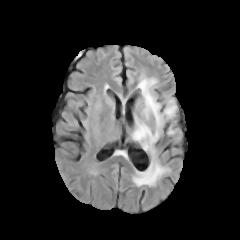

In [ ]:
# Muestro los valores de la energía normalizados por el valor máximo para fijarme en las imágenes y compararlas, a ver cómo afecta el valor de energía

df.energy.head(10)/df.energy.max()

0    0.497411
1    0.805606
2    0.054125
3    0.054307
4    0.583110
5    0.714941
6    0.543810
7    0.494031
8    0.462090
9    0.077474
Name: energy, dtype: float64

In [ ]:
# Defino una función para graficar distribuciones de barras con porcentajes

def graficar_porcentajes(data, variable, xtickslabels, xlabel):

  ax = sns.countplot(x=variable, data=data,  color='#3692DE')
  ax.set(ylabel='Bar Count', title='Bar Count and Percent of Total')

  for c in ax.containers:

      labels = [f'{h/data[variable].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]

      ax.bar_label(c, labels=labels, label_type='edge')

  ax.set_xticklabels(xtickslabels)
  ax.set_ylabel('Count')
  ax.set_xlabel(xlabel)
  plt.show()

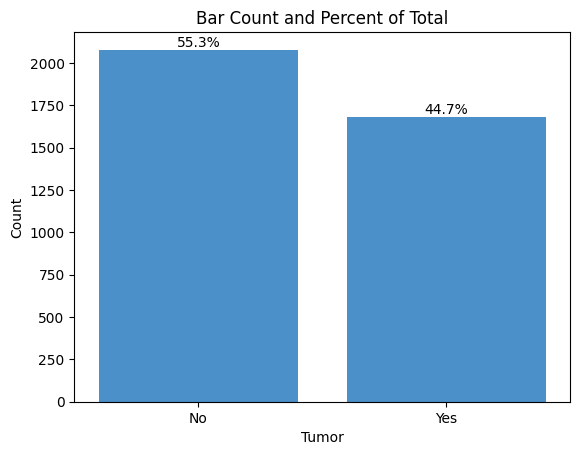

In [ ]:
graficar_porcentajes(data=df, variable='tumor', xtickslabels=['No', 'Yes'], xlabel='Tumor')

In [5]:
X_1st = df[['mean',	'variance',	'standard_deviation', 'skewness',	'kurtosis', 'tumor']]
X_2nd = df[['entropy',	'contrast',	'energy',	'ASM',	'homogeneity',	'dissimilarity',	'correlation', 'tumor']]

# La variable 'coarseness' no la tengo en cuenta porque siempre tiene un valor constante

In [ ]:
# Esta función realiza distintos gráficos de distribuciones para una variable

def stats_graphs(data, variable, hue):
  if hue==True:
    print('VARIABLE:', variable)
    print('')
    print('Max:', round(data[variable].max(), 4))
    print('Mean:', round(data[variable].mean(), 4))
    print('Median:', round(data[variable].median(), 4))
    print('Std:', round(data[variable].std(), 4))
    print('Min:', round(data[variable].min(), 4))
    print('')
    print('')
    sns.boxplot(data=data, x=variable, hue='tumor').set(title='Boxplot');
    plt.show()
    print('')
    sns.displot(data=df, x=variable, hue='tumor', kind='kde').set(title='Distribution barplot')._legend.remove();
    plt.legend(title='Tumor', loc='best', labels=['Yes', 'No'])
    plt.show()
    print('')
    sns.displot(data=df, x=variable, hue='tumor').set(title='Distribution barplot')._legend.remove();
    plt.legend(title='Tumor', loc='best', labels=['Yes', 'No'])                                                   # bbox_to_anchor=(1.30, 0.5)
    plt.show()
    print('')
    print('')
    print('----------------------------------------------------------')
    print('')
    print('')
  elif hue==False:
    print('VARIABLE:', variable)
    print('')
    print('Max:', round(data[variable].max(), 4))
    print('Mean:', round(data[variable].mean(), 4))
    print('Median:', round(data[variable].median(), 4))
    print('Std:', round(data[variable].std(), 4))
    print('Min:', round(data[variable].min(), 4))
    print('')
    print('')
    sns.boxplot(data=data, x=variable).set(title='Boxplot');
    plt.show()
    print('')
    sns.displot(data=data, x=variable, kind='kde').set(title='Distribution plot');
    plt.show()
    print('')
    sns.displot(data=data, x=variable).set(title='Distribution barplot');
    plt.show()
    print('')
    print('')
    print('----------------------------------------------------------')
    print('')
    print('')

In [ ]:
X_1st

,mean,variance,standard_deviation,skewness,kurtosis,tumor
0,6.535339,619.587845,24.891522,4.276477,18.900575,0
1,8.749969,805.957634,28.389393,3.718116,14.464618,0
2,7.341095,1143.808219,33.820234,5.061750,26.479563,1
3,5.958145,959.711985,30.979219,5.677977,33.428845,1
4,7.315231,729.540579,27.010009,4.283221,19.079108,0
...,...,...,...,...,...,...
3757,21.234512,1208.850174,34.768523,2.082079,4.647310,0
3758,20.435349,1227.151440,35.030721,2.144625,4.882034,0
3759,18.011520,1151.582765,33.934978,2.308349,5.579498,0
3760,13.330429,945.732779,30.752769,2.732822,7.757570,0


VARIABLE: mean

Max: 33.24
Mean: 9.4889
Median: 8.4775
Std: 5.728
Min: 0.0787




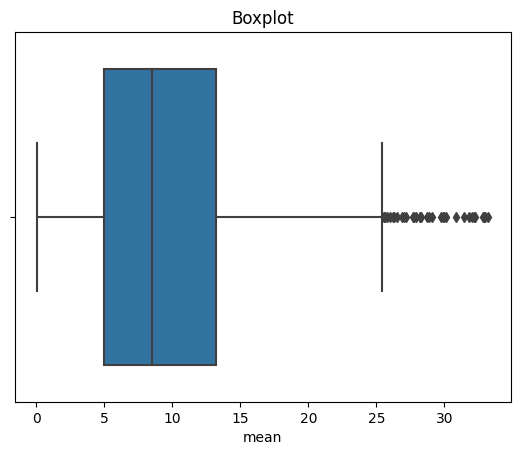

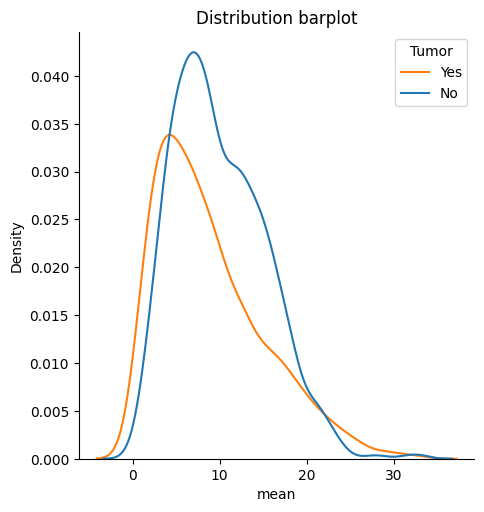

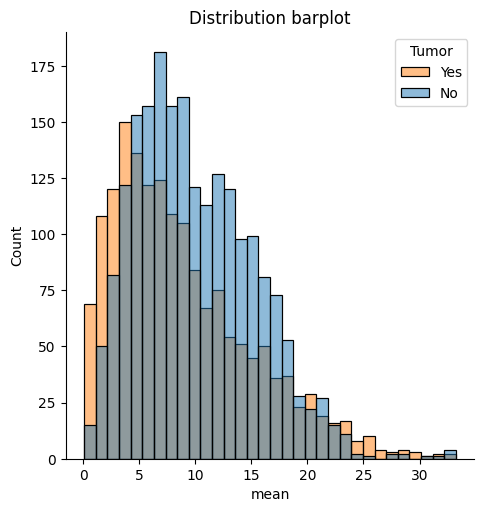



----------------------------------------------------------


VARIABLE: variance

Max: 2910.5819
Mean: 711.1011
Median: 622.5804
Std: 467.4669
Min: 3.1456




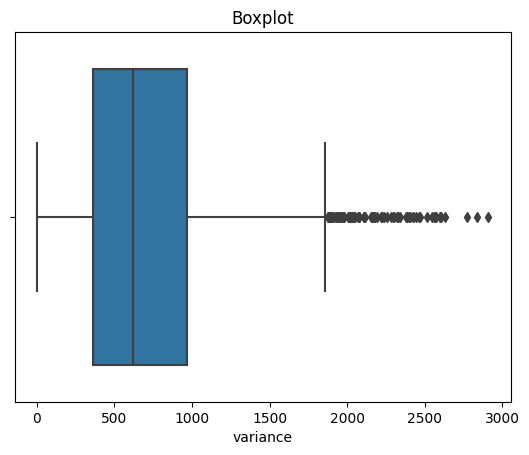

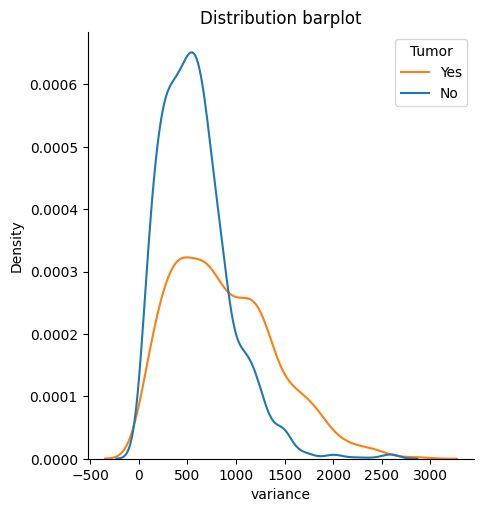

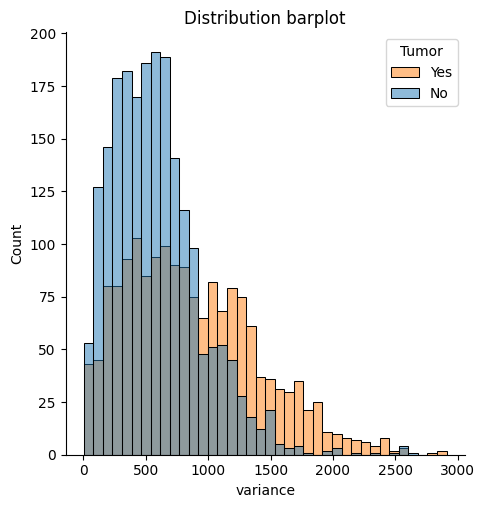



----------------------------------------------------------


VARIABLE: standard_deviation

Max: 53.9498
Mean: 25.1823
Median: 24.9516
Std: 8.7735
Min: 1.7736




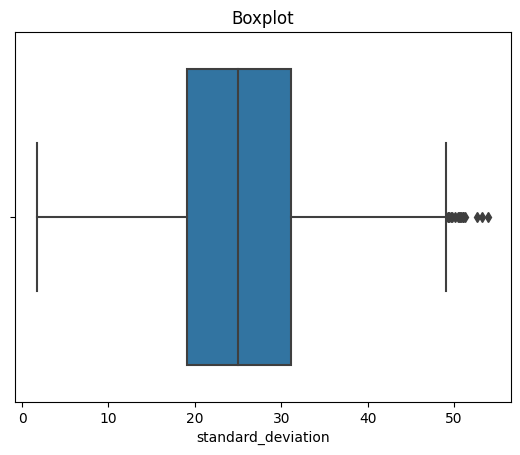

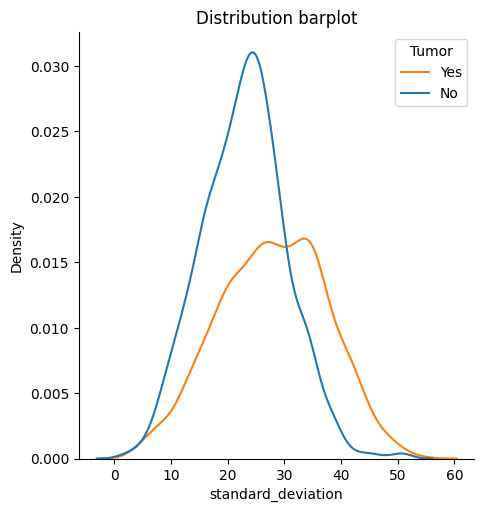

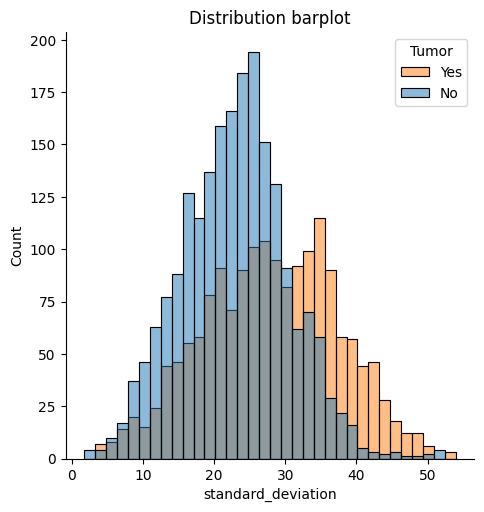



----------------------------------------------------------


VARIABLE: skewness

Max: 36.9313
Mean: 4.1027
Median: 3.4222
Std: 2.5609
Min: 1.886




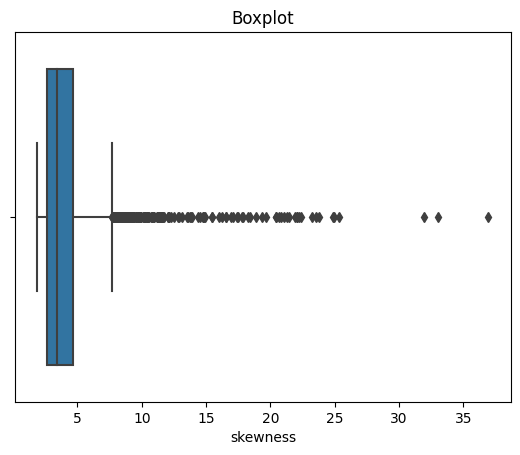

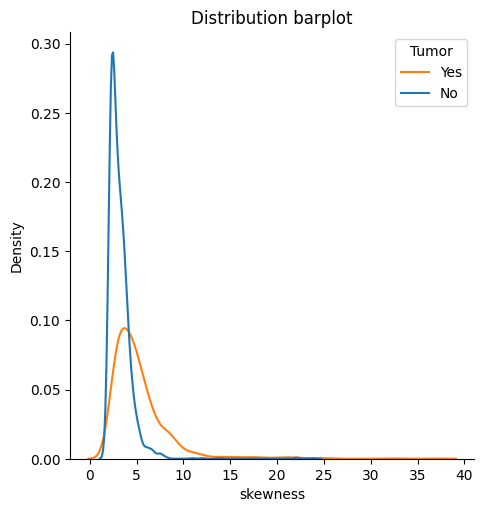

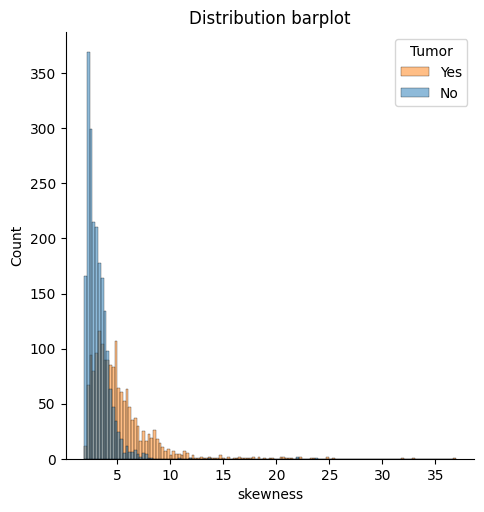



----------------------------------------------------------


VARIABLE: kurtosis

Max: 1371.6401
Mean: 24.3891
Median: 12.3591
Std: 56.4347
Min: 3.9424




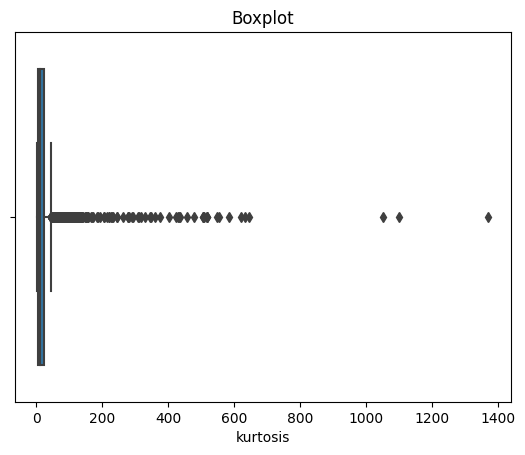

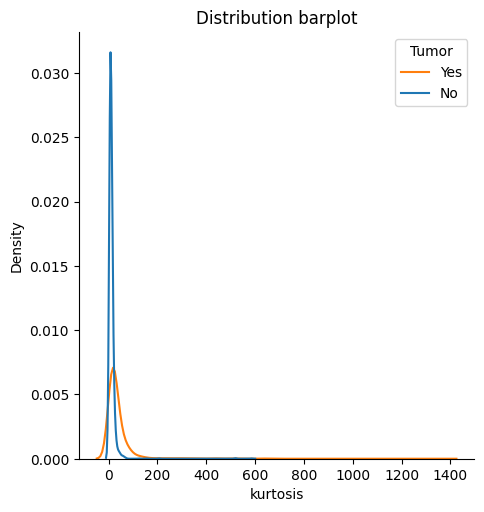

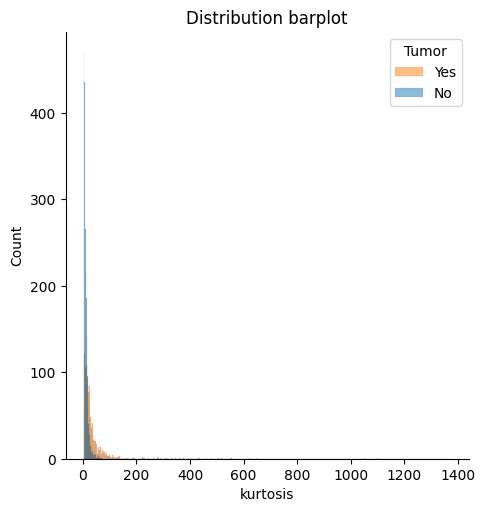



----------------------------------------------------------




In [ ]:
# First order features

for i in X_1st.drop('tumor', axis=1).columns:
  stats_graphs(data=X_1st, variable=i, hue=True)

VARIABLE: entropy

Max: 0.3945
Mean: 0.0736
Median: 0.0666
Std: 0.0703
Min: 0.0009




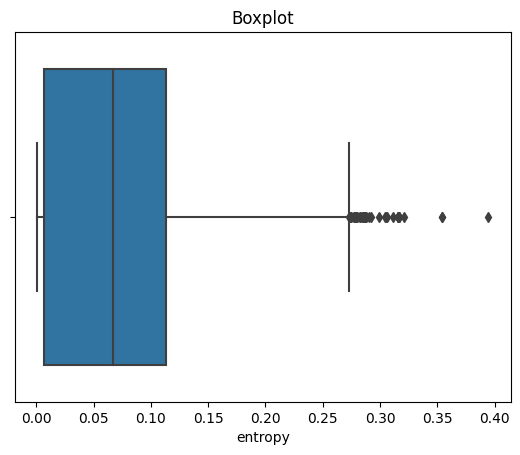

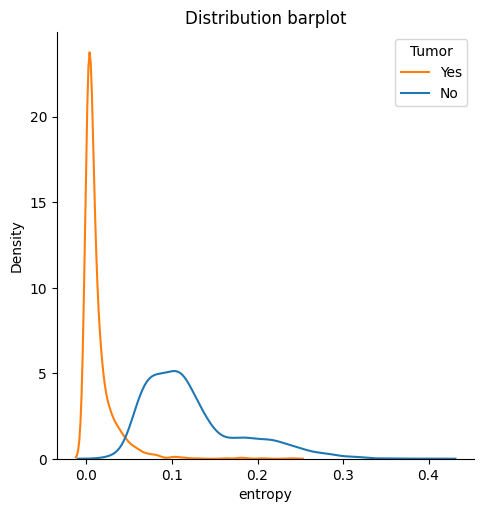

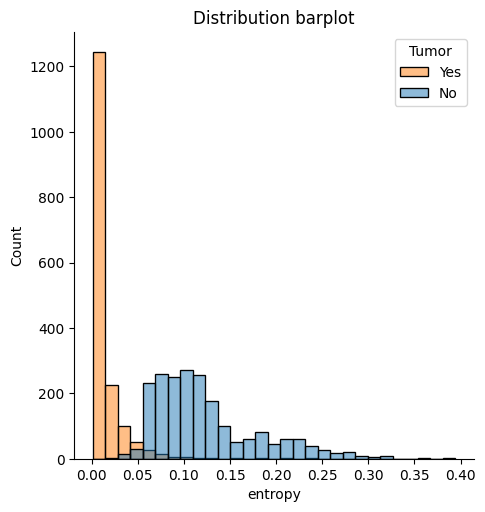



----------------------------------------------------------


VARIABLE: contrast

Max: 3382.5742
Mean: 127.9615
Median: 106.7374
Std: 109.4996
Min: 3.1947




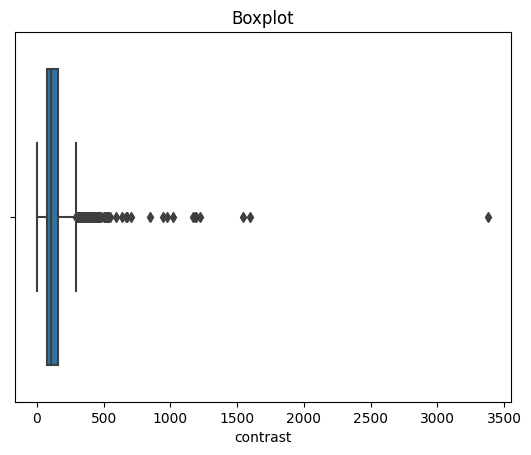

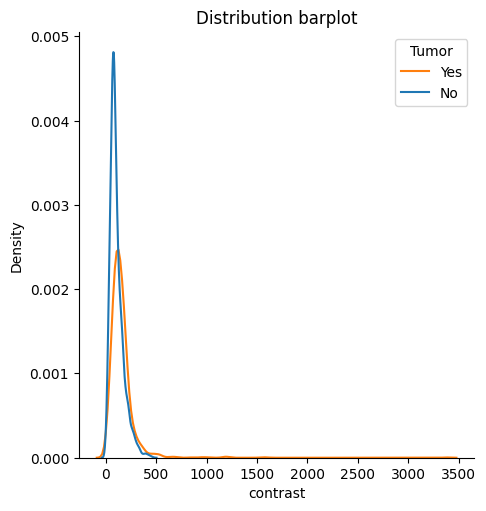

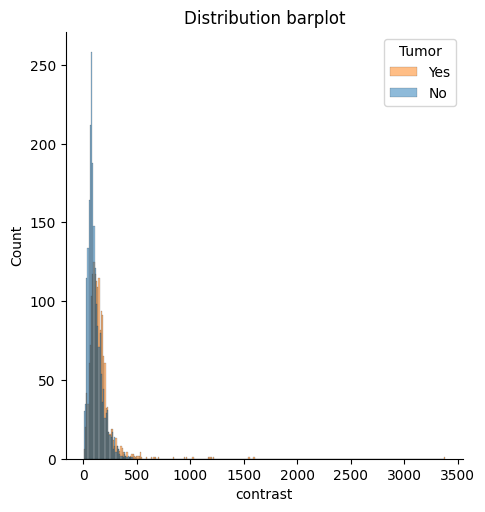



----------------------------------------------------------


VARIABLE: energy

Max: 0.5897
Mean: 0.2047
Median: 0.2255
Std: 0.1294
Min: 0.0247




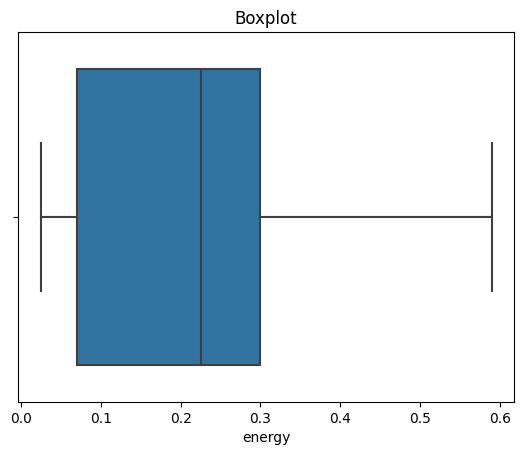

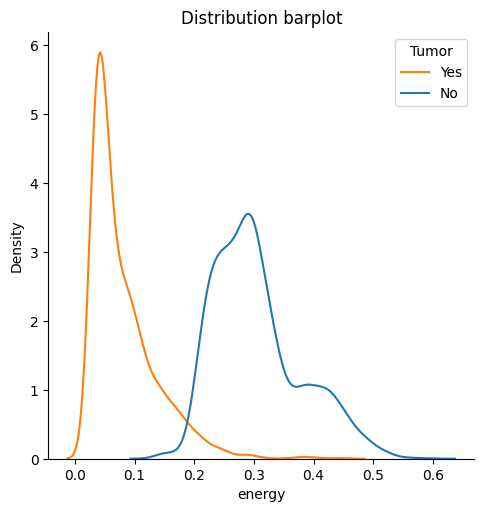

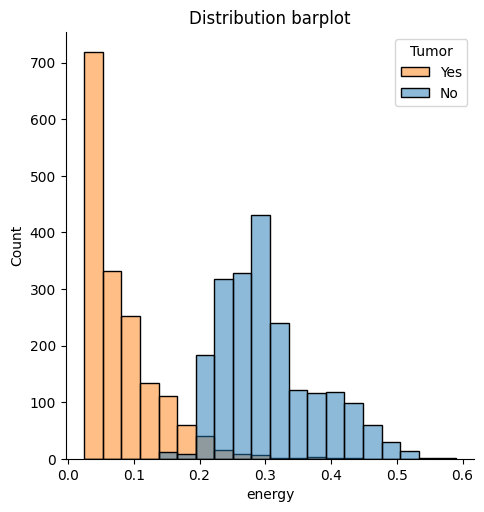



----------------------------------------------------------


VARIABLE: ASM

Max: 0.3477
Mean: 0.0586
Median: 0.0508
Std: 0.0583
Min: 0.0006




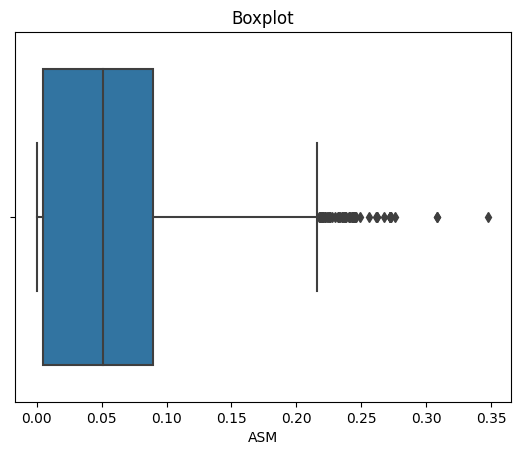

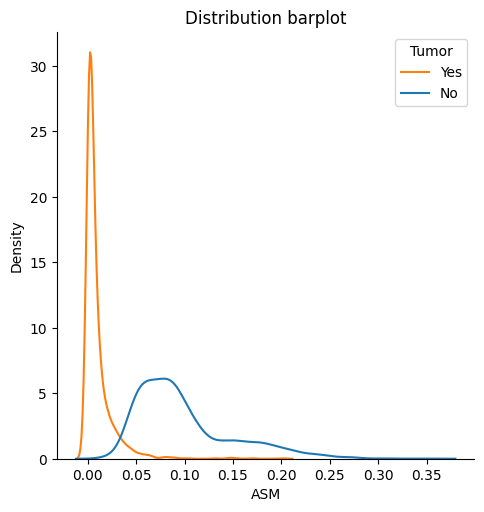

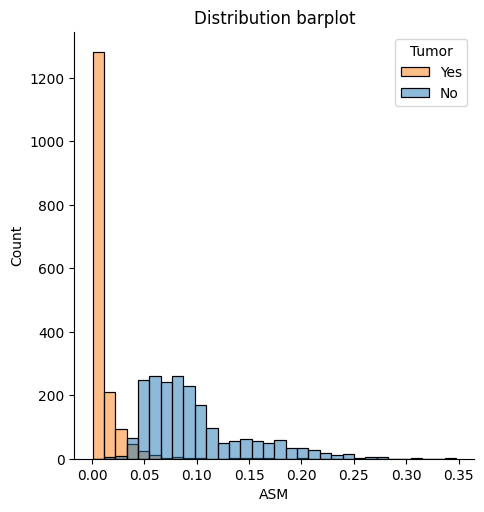



----------------------------------------------------------


VARIABLE: homogeneity

Max: 0.8109
Mean: 0.4793
Median: 0.5126
Std: 0.1279
Min: 0.1055




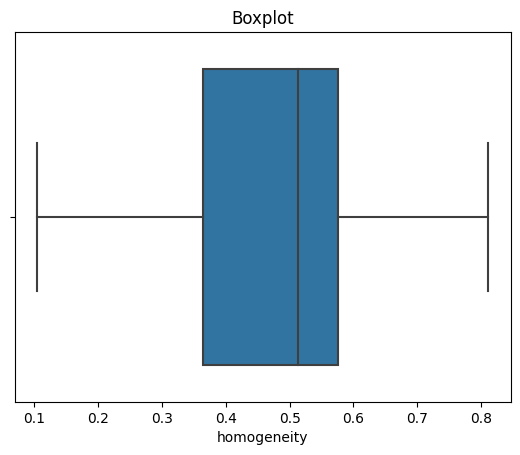

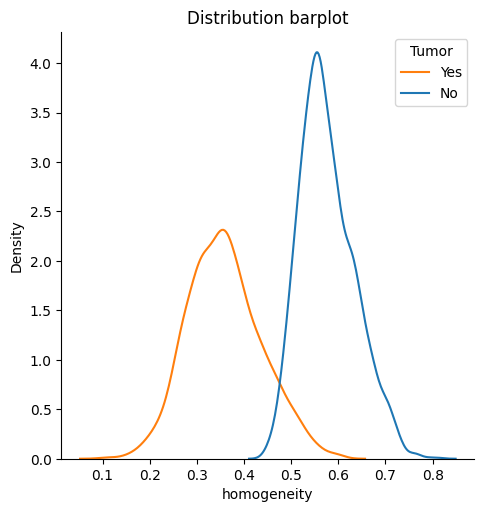

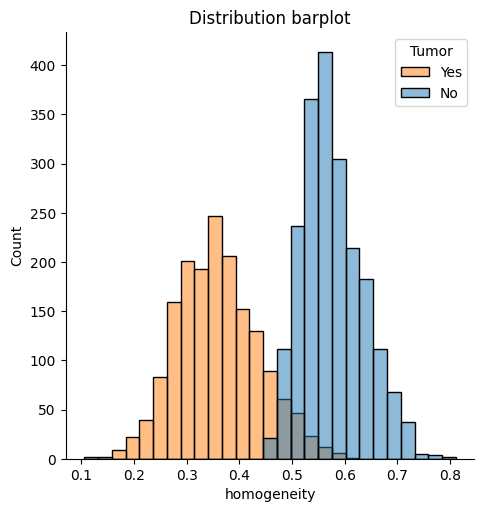



----------------------------------------------------------


VARIABLE: dissimilarity

Max: 27.8278
Mean: 4.6985
Median: 4.4824
Std: 1.8502
Min: 0.6811




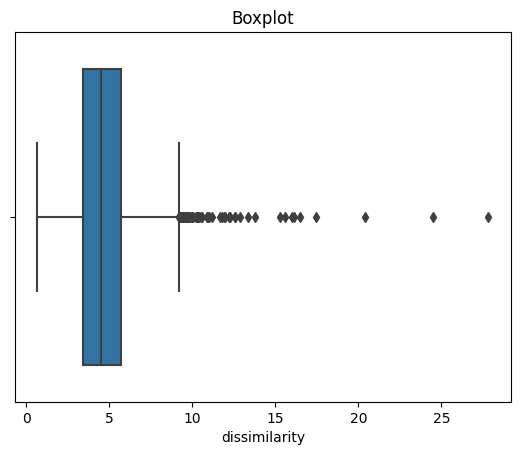

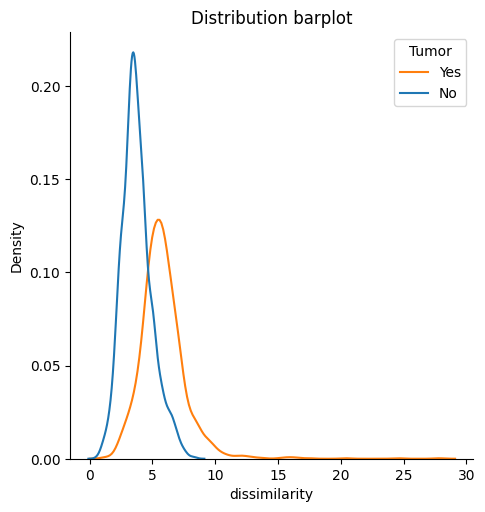

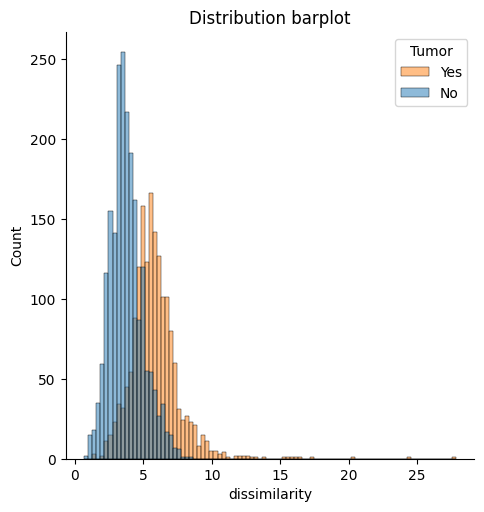



----------------------------------------------------------


VARIABLE: correlation

Max: 0.99
Mean: 0.9558
Median: 0.9616
Std: 0.0262
Min: 0.5494




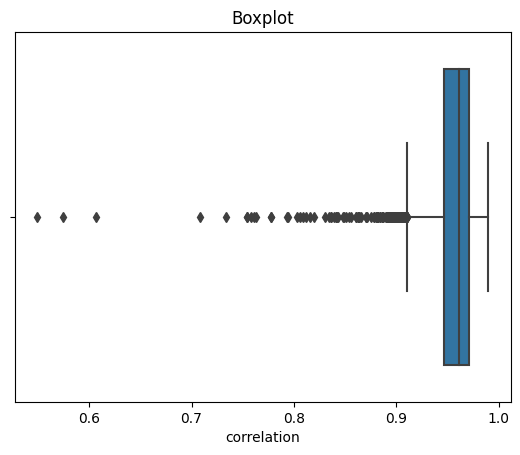

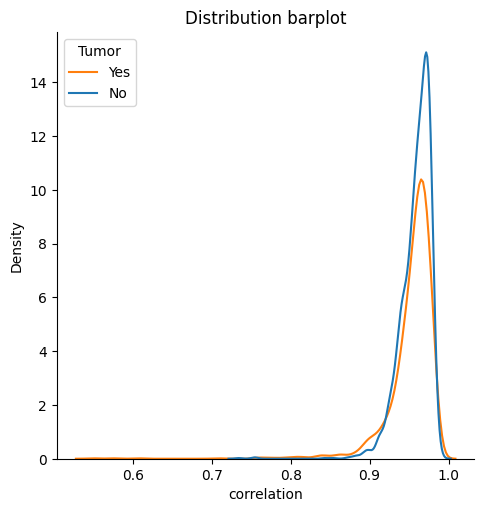

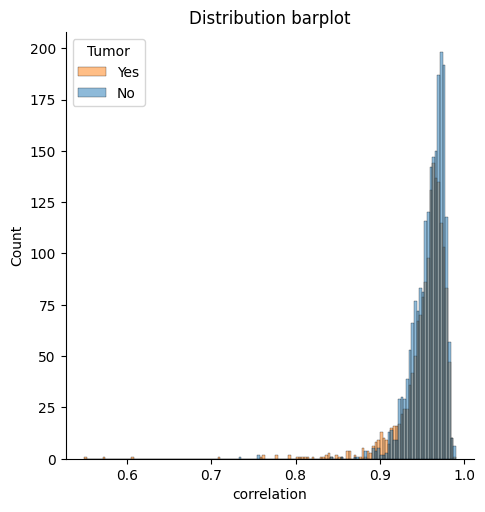



----------------------------------------------------------




In [ ]:
# Second Order features

for i in X_2nd.drop('tumor', axis=1).columns:
  stats_graphs(data=X_2nd, variable=i, hue=True)

In [ ]:
X_2nd.coarseness

0       7.458341e-155
1       7.458341e-155
2       7.458341e-155
3       7.458341e-155
4       7.458341e-155
            ...      
3757    7.458341e-155
3758    7.458341e-155
3759    7.458341e-155
3760    7.458341e-155
3761    7.458341e-155
Name: coarseness, Length: 3762, dtype: float64

In [ ]:
# Puedo normalizar esta variable.

In [ ]:
X_2nd.coarseness.max()

7.45834073120021e-155

In [ ]:
X_2nd['norm_coarseness'] = X_2nd.coarseness/X_2nd.coarseness.max()

<ipython-input-14-c48ce4f17e06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2nd['norm_coarseness'] = X_2nd.coarseness/X_2nd.coarseness.max()


In [ ]:
X_2nd

,entropy,contrast,energy,ASM,homogeneity,dissimilarity,correlation,coarseness,tumor,norm_coarseness
0,0.109059,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155,0,1.0
1,0.266538,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155,0,1.0
2,0.001467,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155,1,1.0
3,0.001477,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155,1,1.0
4,0.146761,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155,0,1.0
...,...,...,...,...,...,...,...,...,...,...
3757,0.063774,158.437600,0.220666,0.048693,0.487131,5.211739,0.950972,7.458341e-155,0,1.0
3758,0.066763,161.158675,0.225931,0.051045,0.502712,5.083126,0.952749,7.458341e-155,0,1.0
3759,0.068396,167.130118,0.228930,0.052409,0.492269,5.103700,0.952181,7.458341e-155,0,1.0
3760,0.087872,223.812932,0.261527,0.068397,0.480064,6.439784,0.940898,7.458341e-155,0,1.0


In [ ]:
X_2nd.coarseness.unique()

In [ ]:
# Tiene el mismo valor todo el rato

https://www.scirp.org/html/2-3400180_19553.htm \\
https://juliaimages.org/ImageFeatures.jl/stable/tutorials/glcm/

In [ ]:
# Visualizo variables con outliers quitándolos.

In [ ]:
def perc_graph(data, variable, perc):
  percentil = np.percentile(data[variable], perc)
  sns.displot(data=data[data[variable]<=percentil], x=variable, hue='tumor', kind='kde');
  plt.show()
  print('')

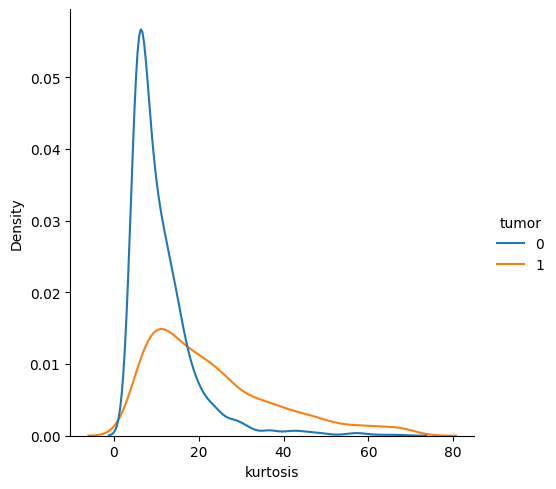

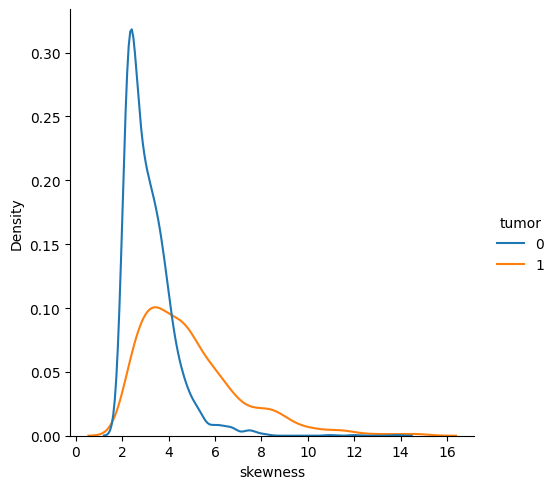

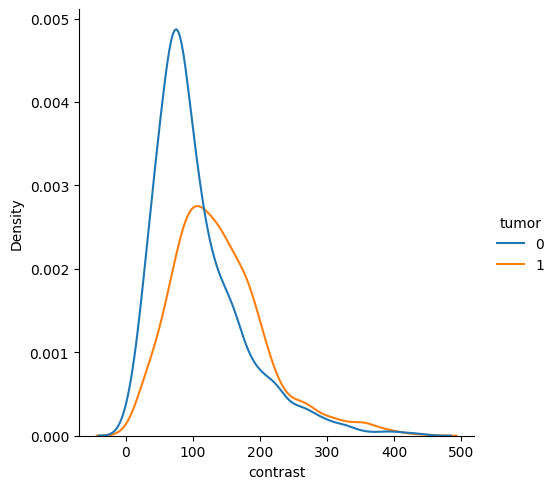

In [ ]:
perc_graph(data=df, variable='kurtosis', perc=95)
perc_graph(data=df, variable='skewness', perc=99)
perc_graph(data=df, variable='contrast', perc=99)

In [ ]:
# Las variables entropy, energy, ASM, homogeneity parece interesante pq distingue bastante entre Tumor y No tumor.

##MATRIZ CORRELACIÓN

In [ ]:
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
#------------------------MATRIZ DE CORRELACIÓN---------------------------------#
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#

In [ ]:
def grafica_correlacion(data):

    data_a_dibujar=data

    if len(data_a_dibujar)==0:
      print('No existen datos')

    else:
      #fig, ax = plt.subplots(figsize=(7,7))
      fig, ax = plt.subplots(figsize=(10,10))

      sns.heatmap(data_a_dibujar.corr(), vmin=-1, vmax=1, annot=True,
                      square = True,
                            linewidths = .5,
                            cmap = 'coolwarm',
                            cbar_kws = {'shrink': .4,'ticks' : [-1, -.5, 0, 0.5, 1]}
                            , annot_kws = {'size': 12}, ax=ax).set(title='Correlation matrix');
      plt.show()
    correlation_triu = data_a_dibujar.corr().where(np.triu(np.ones(data_a_dibujar.corr().shape), k=1).astype(bool))      #La función np.triu trianguliza la matriz superior dado que es simétrica y se obtendrían las parejas de variables repetidas.
    correlation_pairs = correlation_triu.unstack().sort_values(ascending=False)
    top_correlation_pairs = correlation_pairs[correlation_pairs < 1]#.head(5)

    print('')
    print('Parejas de variables con correlación ordenadas de mayor a menor:')
    print('')
    print(round(top_correlation_pairs, 4))

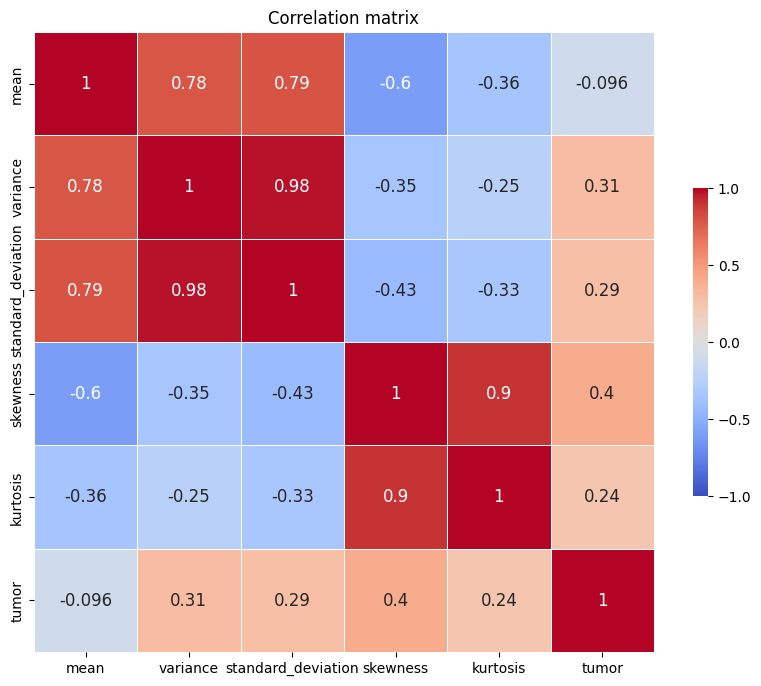


Parejas de variables con correlación ordenadas de mayor a menor:

standard_deviation  variance              0.9757
kurtosis            skewness              0.8997
standard_deviation  mean                  0.7910
variance            mean                  0.7830
tumor               skewness              0.4026
                    variance              0.3088
                    standard_deviation    0.2856
                    kurtosis              0.2398
                    mean                 -0.0957
kurtosis            variance             -0.2483
                    standard_deviation   -0.3298
skewness            variance             -0.3474
kurtosis            mean                 -0.3582
skewness            standard_deviation   -0.4254
                    mean                 -0.6016
dtype: float64


In [ ]:
grafica_correlacion(data=X_1st)

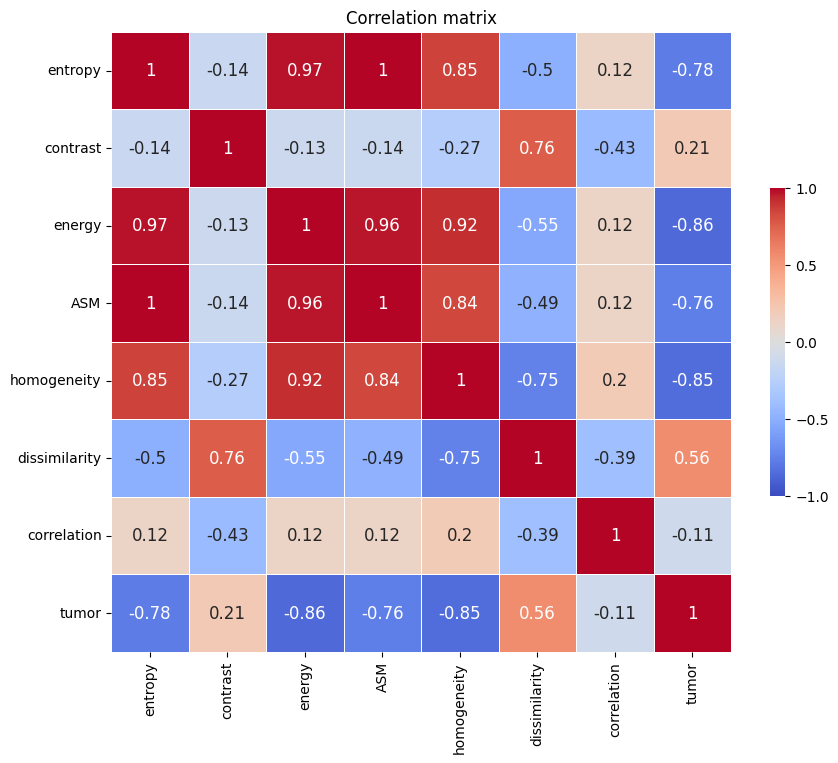


Parejas de variables con correlación ordenadas de mayor a menor:

ASM            entropy          0.9992
energy         entropy          0.9713
ASM            energy           0.9616
homogeneity    energy           0.9160
               entropy          0.8520
               ASM              0.8371
dissimilarity  contrast         0.7615
tumor          dissimilarity    0.5563
               contrast         0.2126
correlation    homogeneity      0.1986
               energy           0.1237
               entropy          0.1221
               ASM              0.1211
tumor          correlation     -0.1086
energy         contrast        -0.1307
ASM            contrast        -0.1393
contrast       entropy         -0.1408
homogeneity    contrast        -0.2701
correlation    dissimilarity   -0.3930
               contrast        -0.4274
dissimilarity  ASM             -0.4918
               entropy         -0.5024
               energy          -0.5458
               homogeneity     -0.74

In [ ]:
grafica_correlacion(data=X_2nd)

##MODELOS CLASIFICACIÓN

In [ ]:
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
#------------------------MODELOS CLASIFICACIÓN---------------------------------#
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#

In [28]:
# La función recibe los datos X (features) e Y (target) y calcula modelo KNN y TREE para AMBOS conjuntos.
# Devuelve los parámetros de perfomance para conjunto test y puede también devolverlos para train.
# Esta función no está tan completa como las siguientes puesto que no se utiliza, solo es una primera versión.
# Se deja en el código para visualizarla

def funcion_clasificacion(X, y, show_train_results=False):
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.metrics import accuracy_score, confusion_matrix
  from sklearn import tree
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import classification_report
  from tabulate import tabulate
  from sklearn.model_selection import GridSearchCV
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  # Escalado por si hay que usarlo
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train_scale=scaler.transform(X_train)
  X_test_scale=scaler.transform(X_test)

  # Creamos modelo KNN
  clf_knn = KNeighborsClassifier(n_neighbors=5)
  clf_knn.fit(X_train_scale,y_train)
  y_pred_test_knn = clf_knn.predict(X_test_scale)
  y_pred_train_knn = clf_knn.predict(X_train_scale)

  # Creamos modelo Tree
  clf_tree = DecisionTreeClassifier(max_depth=2, random_state = 42)
  clf_tree.fit(X_train_scale,y_train)
  y_pred_test_tree = clf_tree.predict(X_test_scale)
  y_pred_train_tree = clf_tree.predict(X_train_scale)


  # Defino una función auxiliar que plotea los resultados según el modelo que se le indique
  def funcioncilla(model):

    if model==clf_knn:
      nombre='KNN'
      y_pred_test=y_pred_test_knn
      y_pred_train=y_pred_train_knn
    elif model==clf_tree:
      nombre='DECISION TREE'
      y_pred_test=y_pred_test_tree
      y_pred_train=y_pred_train_tree

    print(nombre)
    # Muestro resultados en conjunto TEST. Accuracy score y después confusion matrix.
    print('')
    print('Test')
    print('Accuracy score', nombre, ' y_test: ', round(accuracy_score(y_test,y_pred_test), 4))
    print('Confusion matrix', nombre, ' y_test:')


    # Esto de abajo de una forma simple de mostrar la matriz.
    #print(confusion_matrix(y_test, y_pred_test))


    # Muestra la matrix más estética
    cm = sns.light_palette("lightblue", as_cmap=True)
    x1=pd.DataFrame(confusion_matrix(y_test, y_pred_test))
    vmin1=confusion_matrix(y_test, y_pred_test).min()
    vmax1=confusion_matrix(y_test, y_pred_test).max()
    x1=x1.style.background_gradient(cmap=cm, vmin=vmin1, vmax=vmax1)
    display(x1)
    report = classification_report(y_test, y_pred_test, target_names=['Tumor = No', 'Tumor = Yes'], output_dict=True)
    print('')
    df_report = pd.DataFrame(report).transpose().round(4)
    df_report.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)

    # Formatear la tabla utilizando tabulate
    table = tabulate(df_report, headers='keys', tablefmt='grid')


    # Imprimir la tabla
    print('')
    print(table)
    print('')
    print('')


    # Esto hace lo mismo con conjunto train. En principio no se muestra porque no es necesario.
    if show_train_results==True:

      print('Train')
      print('Accuracy score', nombre, ' y_train: ', round(accuracy_score(y_train,y_pred_train), 4))
      print('Confusion matrix', nombre, ' y_train:')
      #print(confusion_matrix(y_train, y_pred_train))
      x2=pd.DataFrame(confusion_matrix(y_train, y_pred_train))
      vmin2=confusion_matrix(y_train, y_pred_train).min()
      vmax2=confusion_matrix(y_train, y_pred_train).max()
      x2=x2.style.background_gradient(cmap=cm, vmin=vmin2, vmax=vmax2)
      display(x2)


      report = classification_report(y_train, y_pred_train, target_names=['Tumor = No', 'Tumor = Yes'], output_dict=True)
      df_report = pd.DataFrame(report).transpose().round(4)
      df_report.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)


      table = tabulate(df_report, headers='keys', tablefmt='grid')


      print('')
      print(table)

    print('')
    print('')
    print('-------------------------------------------------------------------')
    print('')
    print('')


    # Si el modelo es el decision tree, grafico sus feature importances y la propia imagen del árbol
    if model==clf_tree:
      importances = model.feature_importances_
      columns = X_train.columns
      sns.barplot(x=importances, y=columns, color='#3692DE')
      plt.title('Importancia de cada Feature')
      plt.show();
      print('')

      plt.figure(figsize = (10,8))
      tree.plot_tree(model, filled = True, feature_names= X.columns)
      plt.title(nombre)
      plt.show()


  # Uso la función auxiliar en los dos modelos
  funcioncilla(model=clf_knn)
  funcioncilla(model=clf_tree)

In [79]:
def funcion_clasificacion_grid(X, y, show_train_results=False):                                  #La función recibe los datos train y test y calcula modelo KNN y TREE para AMBOS conjuntos, es decir devuelve 4 resultados
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.metrics import accuracy_score, confusion_matrix
  from sklearn import tree
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import classification_report
  from tabulate import tabulate
  from sklearn.model_selection import GridSearchCV

  # Defino conjuntos train y test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Escalado
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train_scale=scaler.transform(X_train)
  X_test_scale=scaler.transform(X_test)


  # Hago grid search del modelo KNN. Lo entreno y defino el modelo con los mejores parámetros
  param_grid_knn = {'n_neighbors' : [1, 2, 5, 7, 10, 20, 50, 100],
              'weights' : ['uniform', 'distance'],
              'leaf_size' : [10, 20, 30, 50, 100]}


  model_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, cv=5)
  model_knn.fit(X_train_scale, y_train)
  best_params_knn = model_knn.best_params_

  clf_knn = KNeighborsClassifier(n_neighbors = best_params_knn['n_neighbors'], weights = best_params_knn['weights'], leaf_size = best_params_knn['leaf_size'])

  clf_knn.fit(X_train_scale, y_train)
  y_pred_train_knn = clf_knn.predict(X_train_scale)
  y_pred_test_knn = clf_knn.predict(X_test_scale)


  # Hago lo mismo con decision tree
  param_grid_tree = {'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_depth' : [10,50,100,150,200,500]}
  model_tree = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid_tree, cv=5)
  model_tree.fit(X_train_scale, y_train)
  best_params_tree = model_tree.best_params_

  clf_tree = DecisionTreeClassifier(criterion = best_params_tree['criterion'], max_depth = best_params_tree['max_depth'])

  clf_tree.fit(X_train_scale, y_train)
  y_pred_train_tree = clf_tree.predict(X_train_scale)
  y_pred_test_tree = clf_tree.predict(X_test_scale)

  print('Bestr params grid search')
  print('')
  print('KNN:', 'n_neighbors =', best_params_knn['n_neighbors'], ', weights =', best_params_knn['weights'], ', leaf_size =', best_params_knn['leaf_size'])
  print('')
  print('Decision Tree:', 'criterion =', best_params_tree['criterion'], ', max_depth =', best_params_tree['max_depth'])


  # Defino una función auxiliar que plotea los resultados según el modelo que se le indique
  def funcioncilla(model):

    if model==clf_knn:
      nombre='KNN'
      y_pred_test=y_pred_test_knn
      y_pred_train=y_pred_train_knn
    elif model==clf_tree:
      nombre='DECISION TREE'
      y_pred_test=y_pred_test_tree
      y_pred_train=y_pred_train_tree

    print(nombre)

    accuracy_model = round(accuracy_score(y_test,y_pred_test), 4)
    # Muestro resultados en conjunto TEST. Accuracy score y después confusion matrix.
    print('')
    print('Test')
    print('Accuracy score', nombre, ' y_test: ', accuracy_model)
    print('Confusion matrix', nombre, ' y_test:')

    # Esto de abajo de una forma simple de mostrar la matriz.
    #print(confusion_matrix(y_test, y_pred_test))


    # Muestra la matrix más estética
    cm = sns.light_palette("lightblue", as_cmap=True)
    x1=pd.DataFrame(confusion_matrix(y_test, y_pred_test))
    vmin1=confusion_matrix(y_test, y_pred_test).min()
    vmax1=confusion_matrix(y_test, y_pred_test).max()
    x1=x1.style.background_gradient(cmap=cm, vmin=vmin1, vmax=vmax1)
    display(x1)

    # Muestro el classification report. Creo un dataframe para luego mostrar los resultados con una tabla de forma más visual
    report = classification_report(y_test, y_pred_test, target_names=['Tumor = No', 'Tumor = Yes'], output_dict=True)
    print('')
    df_report = pd.DataFrame(report).transpose().round(4)
    df_report.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)

    # Formateo la tabla utilizando tabulate
    table = tabulate(df_report, headers='keys', tablefmt='grid')


    # Imprimo la tabla
    print('')
    print(table)
    print('')
    print('')



    # Esto hace lo mismo con conjunto train. En principio no se muestra porque no es necesario.
    if show_train_results==True:

      print('Train')
      print('Accuracy score', nombre, ' y_train: ', round(accuracy_score(y_train,y_pred_train), 4))
      print('Confusion matrix', nombre, ' y_train:')
      #print(confusion_matrix(y_train, y_pred_train))
      x2=pd.DataFrame(confusion_matrix(y_train, y_pred_train))
      vmin2=confusion_matrix(y_train, y_pred_train).min()
      vmax2=confusion_matrix(y_train, y_pred_train).max()
      x2=x2.style.background_gradient(cmap=cm, vmin=vmin2, vmax=vmax2)
      display(x2)

      report = classification_report(y_train, y_pred_train, target_names=['Tumor = No', 'Tumor = Yes'], output_dict=True)
      df_report = pd.DataFrame(report).transpose().round(4)
      df_report.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)


      table = tabulate(df_report, headers='keys', tablefmt='grid')


      print('')
      print(table)

    print('')
    print('')
    print('-------------------------------------------------------------------')
    print('')
    print('')


    # Si el modelo es el decision tree, grafico sus feature importances y la propia imagen del árbol
    if model==clf_tree:
      importances = model.feature_importances_
      columns = X_train.columns
      sns.barplot(x=importances, y=columns, color='#3692DE')
      plt.title('Importancia de cada Feature')
      plt.show();
      print('')

      plt.figure(figsize = (10,8))
      tree.plot_tree(model, filled = True, feature_names= X.columns)
      plt.title(nombre)
      plt.show()

    return df_report, accuracy_model


  # Uso la función auxiliar en los dos modelos
  df_KNN, accuracy_KNN = funcioncilla(model=clf_knn)
  df_TREE, accuracy_TREE = funcioncilla(model=clf_tree)

  return df_KNN, accuracy_KNN, df_TREE, accuracy_TREE

In [72]:
def funcion_clasificacion_grid_recall(X, y, show_train_results=False):                                  #La función recibe los datos train y test y calcula modelo KNN y TREE para AMBOS conjuntos, es decir devuelve 4 resultados
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, recall_score
  from sklearn import tree
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import classification_report
  from tabulate import tabulate
  from sklearn.model_selection import GridSearchCV

  # Defino conjuntos train y test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Escalado
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train_scale=scaler.transform(X_train)
  X_test_scale=scaler.transform(X_test)


  # Hago grid search del modelo KNN. Lo entreno y defino el modelo con los mejores parámetros
  param_grid_knn = {'n_neighbors' : [1, 2, 5, 7, 10, 20, 50, 100],
              'weights' : ['uniform', 'distance'],
              'leaf_size' : [10, 20, 30, 50, 100]}

  scorer = make_scorer(recall_score)

  model_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, scoring=scorer)
  model_knn.fit(X_train_scale, y_train)
  best_params_knn = model_knn.best_params_

  clf_knn = KNeighborsClassifier(n_neighbors = best_params_knn['n_neighbors'], weights = best_params_knn['weights'], leaf_size = best_params_knn['leaf_size'])

  clf_knn.fit(X_train_scale, y_train)
  y_pred_train_knn = clf_knn.predict(X_train_scale)
  y_pred_test_knn = clf_knn.predict(X_test_scale)


  # Hago lo mismo con decision tree
  param_grid_tree = {'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_depth' : [10,50,100,150,200,500]}

  scorer = make_scorer(recall_score)

  model_tree = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid_tree, cv=5, scoring=scorer)
  model_tree.fit(X_train_scale, y_train)
  best_params_tree = model_tree.best_params_

  clf_tree = DecisionTreeClassifier(criterion = best_params_tree['criterion'], max_depth = best_params_tree['max_depth'])

  clf_tree.fit(X_train_scale, y_train)
  y_pred_train_tree = clf_tree.predict(X_train_scale)
  y_pred_test_tree = clf_tree.predict(X_test_scale)

  print('Bestr params grid search')
  print('')
  print('KNN:', 'n_neighbors =', best_params_knn['n_neighbors'], ', weights =', best_params_knn['weights'], ', leaf_size =', best_params_knn['leaf_size'])
  print('')
  print('Decision Tree:', 'criterion =', best_params_tree['criterion'], ', max_depth =', best_params_tree['max_depth'])


  # Defino una función auxiliar que plotea los resultados según el modelo que se le indique
  def funcioncilla(model):

    if model==clf_knn:
      nombre='KNN'
      y_pred_test=y_pred_test_knn
      y_pred_train=y_pred_train_knn
    elif model==clf_tree:
      nombre='DECISION TREE'
      y_pred_test=y_pred_test_tree
      y_pred_train=y_pred_train_tree

    print(nombre)

    accuracy_model = round(accuracy_score(y_test,y_pred_test), 4)
    # Muestro resultados en conjunto TEST. Accuracy score y después confusion matrix.
    print('')
    print('Test')
    print('Accuracy score', nombre, ' y_test: ', accuracy_model)
    print('Confusion matrix', nombre, ' y_test:')

    # Esto de abajo de una forma simple de mostrar la matriz.
    #print(confusion_matrix(y_test, y_pred_test))


    # Muestra la matrix más estética
    cm = sns.light_palette("lightblue", as_cmap=True)
    x1=pd.DataFrame(confusion_matrix(y_test, y_pred_test))
    vmin1=confusion_matrix(y_test, y_pred_test).min()
    vmax1=confusion_matrix(y_test, y_pred_test).max()
    x1=x1.style.background_gradient(cmap=cm, vmin=vmin1, vmax=vmax1)
    display(x1)

    # Muestro el classification report. Creo un dataframe para luego mostrar los resultados con una tabla de forma más visual
    report = classification_report(y_test, y_pred_test, target_names=['Tumor = No', 'Tumor = Yes'], output_dict=True)

    print('')
    df_report = pd.DataFrame(report).transpose().round(4)
    df_report.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)

    # Formateo la tabla utilizando tabulate
    table = tabulate(df_report, headers='keys', tablefmt='grid')


    # Imprimo la tabla
    print('')
    print(table)
    print('')
    print('')



    # Esto hace lo mismo con conjunto train. En principio no se muestra porque no es necesario.
    if show_train_results==True:

      print('Train')
      print('Accuracy score', nombre, ' y_train: ', round(accuracy_score(y_train,y_pred_train), 4))
      print('Confusion matrix', nombre, ' y_train:')
      #print(confusion_matrix(y_train, y_pred_train))
      x2=pd.DataFrame(confusion_matrix(y_train, y_pred_train))
      vmin2=confusion_matrix(y_train, y_pred_train).min()
      vmax2=confusion_matrix(y_train, y_pred_train).max()
      x2=x2.style.background_gradient(cmap=cm, vmin=vmin2, vmax=vmax2)
      display(x2)

      report = classification_report(y_train, y_pred_train, target_names=['Tumor = No', 'Tumor = Yes'], output_dict=True)
      df_report = pd.DataFrame(report).transpose().round(4)
      df_report.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)


      table = tabulate(df_report, headers='keys', tablefmt='grid')


      print('')
      print(table)

    print('')
    print('')
    print('-------------------------------------------------------------------')
    print('')
    print('')


    # Si el modelo es el decision tree, grafico sus feature importances y la propia imagen del árbol
    if model==clf_tree:
      importances = model.feature_importances_
      columns = X_train.columns
      sns.barplot(x=importances, y=columns, color='#3692DE')
      plt.title('Importancia de cada Feature')
      plt.show();
      print('')

      plt.figure(figsize = (10,8))
      tree.plot_tree(model, filled = True, feature_names= X.columns)
      plt.title(nombre)
      plt.show()

    return df_report, accuracy_model


  # Uso la función auxiliar en los dos modelos
  df_KNN, accuracy_KNN = funcioncilla(model=clf_knn)
  df_TREE, accuracy_TREE = funcioncilla(model=clf_tree)

  return df_KNN, accuracy_KNN, df_TREE, accuracy_TREE

In [ ]:
#----------------------TODOS LOS FEATURES SIN OPTIMIZAR RECALL ----------------------#

Bestr params grid search

KNN: n_neighbors = 1 , weights = uniform , leaf_size = 10

Decision Tree: criterion = gini , max_depth = 150
KNN

Test
Accuracy score KNN  y_test:  0.9867
Confusion matrix KNN  y_test:


,0,1
0,417,2
1,8,326




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.9812 |   0.9952 |     0.9882 |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.9939 |   0.976  |     0.9849 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------


DECISION TREE

Test
Accuracy score DECISION TREE  y_test:  0.9761
Confusion matrix DECISION TREE  y_test:


,0,1
0,412,7
1,11,323




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.974  |   0.9833 |     0.9786 |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.9788 |   0.9671 |     0.9729 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------




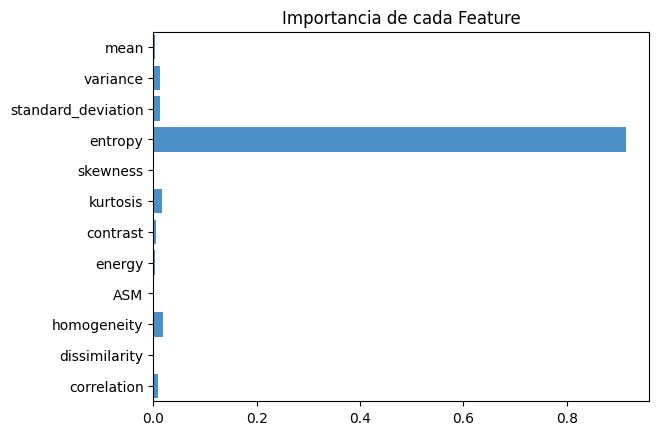

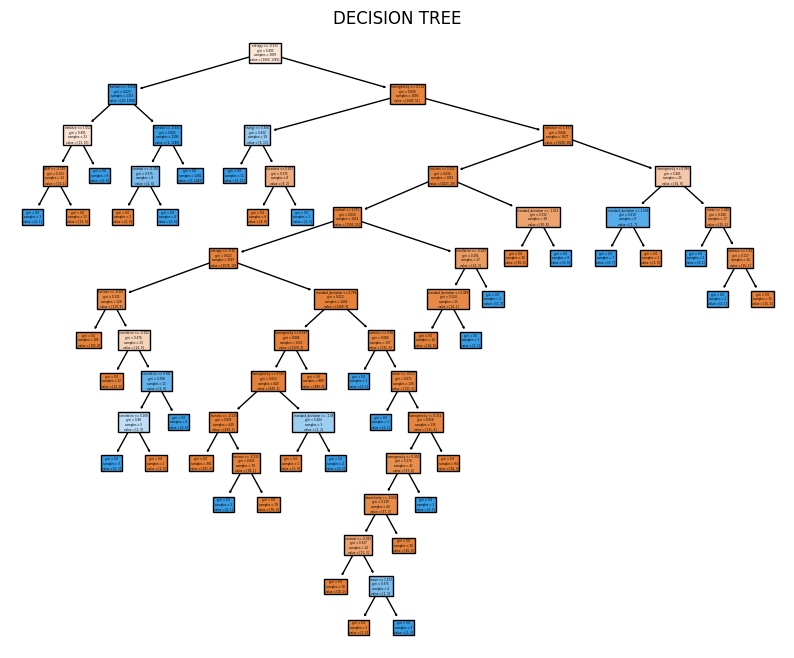

In [80]:
df_X_KNN, acc_X_KNN, df_X_TREE, acc_X_TREE = funcion_clasificacion_grid(X=df.drop(['image', 'tumor', 'coarseness'], axis=1), y=df.tumor)

In [30]:
#----------------------TODOS LOS FEATURES OPTIMIZANDO RECALL ----------------------#

Bestr params grid search

KNN: n_neighbors = 1 , weights = uniform , leaf_size = 10

Decision Tree: criterion = gini , max_depth = 150
KNN

Test
Accuracy score KNN  y_test:  0.9867
Confusion matrix KNN  y_test:


,0,1
0,417,2
1,8,326




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.9812 |   0.9952 |     0.9882 |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.9939 |   0.976  |     0.9849 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------


DECISION TREE

Test
Accuracy score DECISION TREE  y_test:  0.9748
Confusion matrix DECISION TREE  y_test:


,0,1
0,412,7
1,12,322




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.9717 |   0.9833 |     0.9775 |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.9787 |   0.9641 |     0.9713 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------




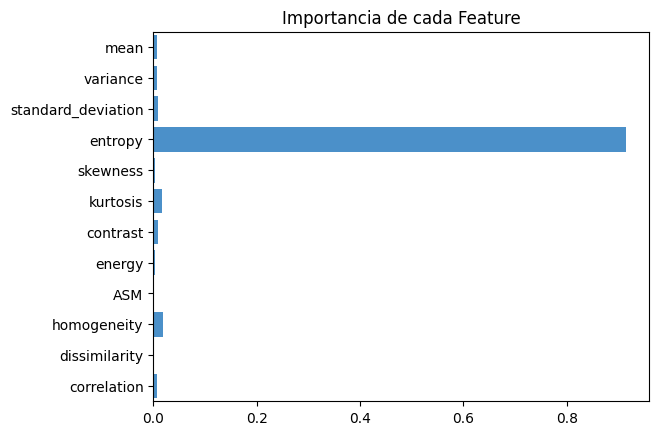

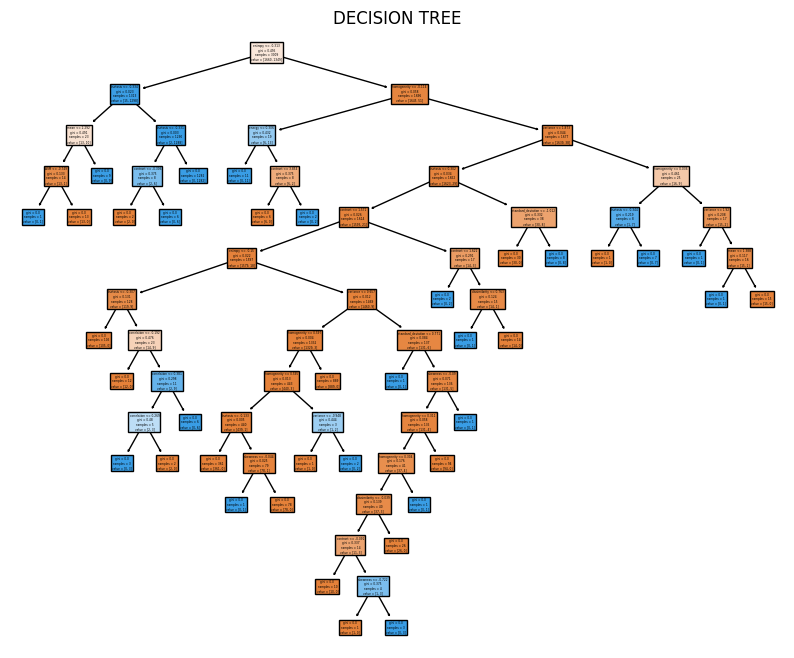

In [74]:
df_X_KNN_recall, acc_X_KNN_recall, df_X_TREE_recall, acc_X_TREE_recall = funcion_clasificacion_grid_recall(X=df.drop(['image', 'tumor', 'coarseness'], axis=1), y=df.tumor)

In [32]:
#----------------------1st-ORDER FEATURES SIN OPTIMIZAR RECALL ----------------------#

Bestr params grid search

KNN: n_neighbors = 10 , weights = distance , leaf_size = 10

Decision Tree: criterion = gini , max_depth = 100
KNN

Test
Accuracy score KNN  y_test:  0.9004
Confusion matrix KNN  y_test:


,0,1
0,391,28
1,47,287




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.8927 |   0.9332 |     0.9125 |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.9111 |   0.8593 |     0.8844 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------


DECISION TREE

Test
Accuracy score DECISION TREE  y_test:  0.911
Confusion matrix DECISION TREE  y_test:


,0,1
0,389,30
1,37,297




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.9131 |   0.9284 |     0.9207 |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.9083 |   0.8892 |     0.8986 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------




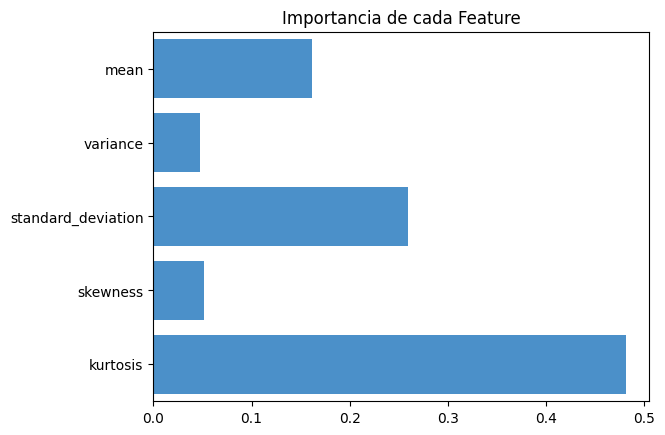

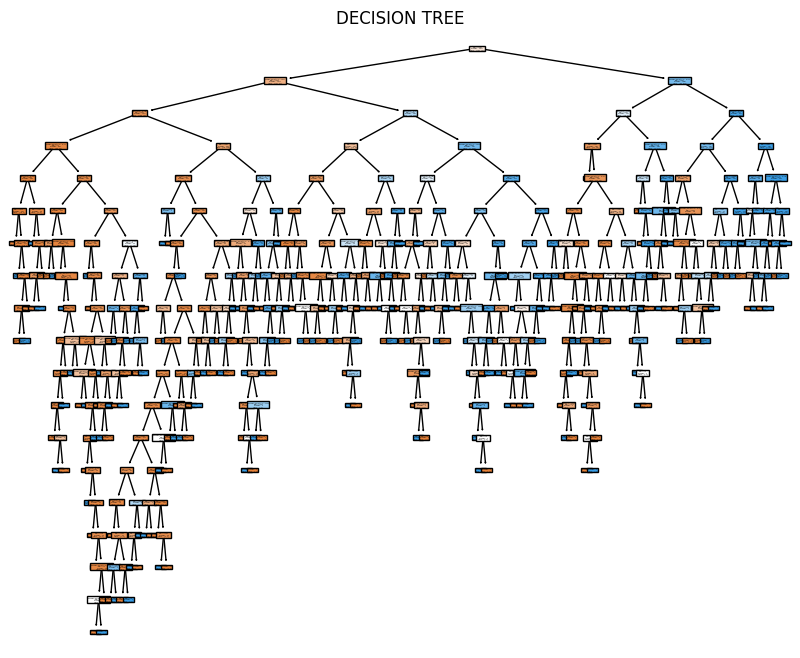

In [81]:
df_X1st_KNN, acc_X1st_KNN, df_X1st_TREE, acc_X1st_TREE = funcion_clasificacion_grid(X=X_1st.drop('tumor', axis=1), y=df.tumor)

In [58]:
#----------------------1st-ORDER FEATURES OPTIMIZANDO RECALL ----------------------#

Bestr params grid search

KNN: n_neighbors = 1 , weights = uniform , leaf_size = 10

Decision Tree: criterion = entropy , max_depth = 500
KNN

Test
Accuracy score KNN  y_test:  0.8977
Confusion matrix KNN  y_test:


,0,1
0,387,32
1,45,289




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.8958 |   0.9236 |     0.9095 |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.9003 |   0.8653 |     0.8824 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------


DECISION TREE

Test
Accuracy score DECISION TREE  y_test:  0.9031
Confusion matrix DECISION TREE  y_test:


,0,1
0,381,38
1,35,299




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.9159 |   0.9093 |     0.9126 |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.8872 |   0.8952 |     0.8912 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------




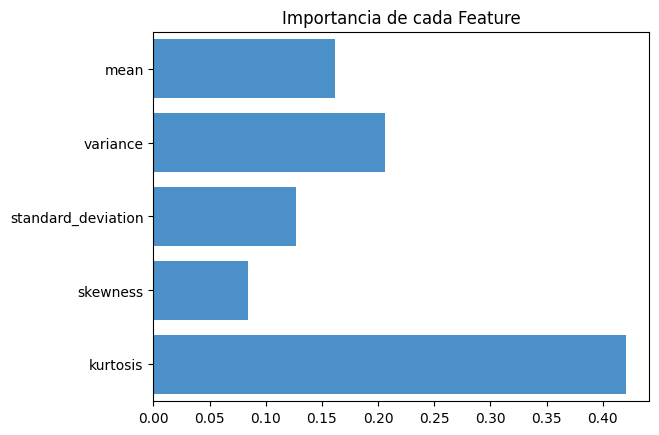

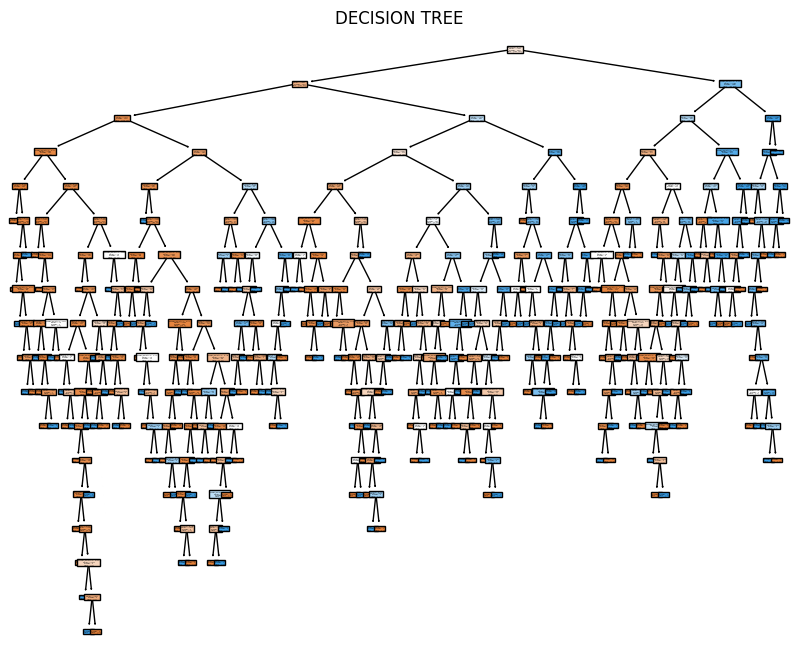

In [87]:
df_X1st_KNN_recall, acc_X1st_KNN_recall, df_X1st_TREE_recall, acc_X1st_TREE_recall = funcion_clasificacion_grid_recall(X=X_1st.drop('tumor', axis=1), y=df.tumor)

In [60]:
#----------------------2nd-ORDER FEATURES SIN OPTIMIZAR RECALL ----------------------#

Bestr params grid search

KNN: n_neighbors = 10 , weights = distance , leaf_size = 10

Decision Tree: criterion = entropy , max_depth = 10
KNN

Test
Accuracy score KNN  y_test:  0.9788
Confusion matrix KNN  y_test:


,0,1
0,417,2
1,14,320




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.9675 |   0.9952 |     0.9812 |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.9938 |   0.9581 |     0.9756 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------


DECISION TREE

Test
Accuracy score DECISION TREE  y_test:  0.9681
Confusion matrix DECISION TREE  y_test:


,0,1
0,406,13
1,11,323




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.9736 |   0.969  |     0.9713 |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.9613 |   0.9671 |     0.9642 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------




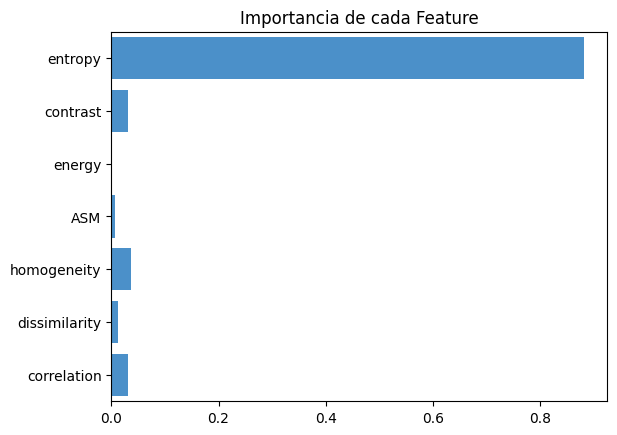

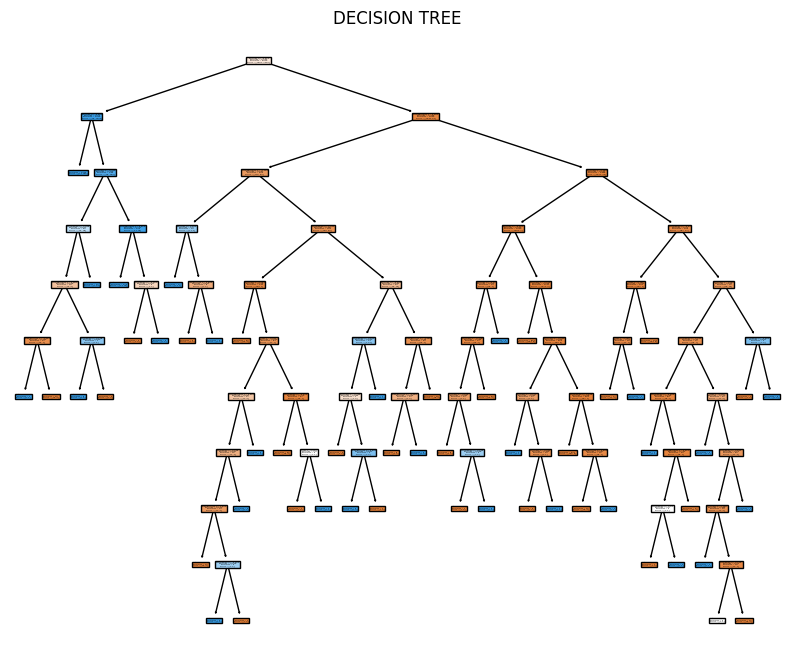

In [90]:
df_X2nd_KNN, acc_X2nd_KNN, df_X2nd_TREE, acc_X2nd_TREE =  funcion_clasificacion_grid(X=X_2nd.drop('tumor', axis=1), y=df.tumor)

In [62]:
#----------------------2nd-ORDER FEATURES OPTIMIZANDO RECALL ----------------------#

Bestr params grid search

KNN: n_neighbors = 1 , weights = uniform , leaf_size = 10

Decision Tree: criterion = entropy , max_depth = 100
KNN

Test
Accuracy score KNN  y_test:  0.9801
Confusion matrix KNN  y_test:


,0,1
0,414,5
1,10,324




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.9764 |   0.9881 |     0.9822 |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.9848 |   0.9701 |     0.9774 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------


DECISION TREE

Test
Accuracy score DECISION TREE  y_test:  0.9721
Confusion matrix DECISION TREE  y_test:


,0,1
0,409,10
1,11,323




+-------------+-------------+----------+------------+-----------+
|             |   precision |   recall |   f1-score |   support |
+=============+=============+==========+============+===========+
| Tumor = No  |      0.9738 |   0.9761 |     0.975  |       419 |
+-------------+-------------+----------+------------+-----------+
| Tumor = Yes |      0.97   |   0.9671 |     0.9685 |       334 |
+-------------+-------------+----------+------------+-----------+




-------------------------------------------------------------------




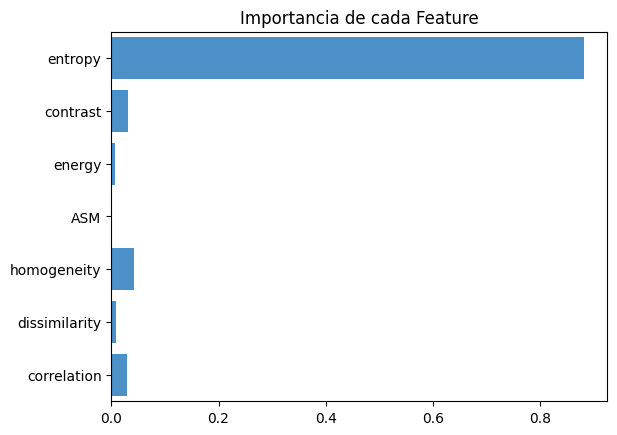

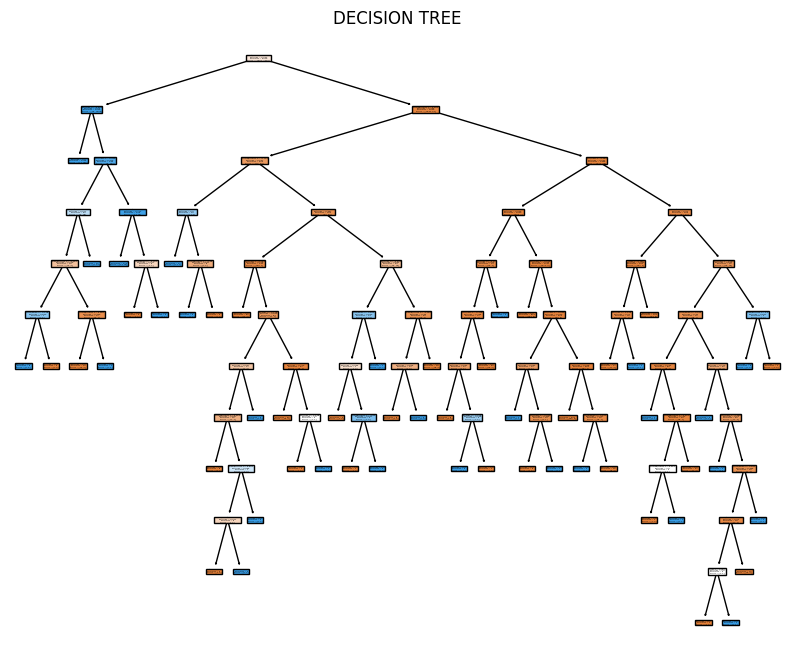

In [85]:
df_X2nd_KNN_recall, acc_X2nd_KNN_recall, df_X2nd_TREE_recall, acc_X2nd_TREE_recall = funcion_clasificacion_grid_recall(X=X_2nd.drop('tumor', axis=1), y=df.tumor)

In [64]:
#----------------------COMPARAMOS TODOS LOS MODELOS----------------------------#

In [88]:
print('KNN, SIN OPTIMIZAR RECALL')
print('')
print('TODOS LOS FEATURES')
print(df_X_KNN)
print('Accuracy:', acc_X_KNN)
print('')
print('')
print('KNN, OPTIMIZANDO RECALL')
print('')
print('TODOS LOS FEATURES')
print(df_X_KNN_recall)
print('Accuracy:', acc_X_KNN_recall)

KNN, SIN OPTIMIZAR RECALL

TODOS LOS FEATURES
             precision  recall  f1-score  support
Tumor = No      0.9812  0.9952    0.9882    419.0
Tumor = Yes     0.9939  0.9760    0.9849    334.0
Accuracy: 0.9867


KNN, OPTIMIZANDO RECALL

TODOS LOS FEATURES
             precision  recall  f1-score  support
Tumor = No      0.9812  0.9952    0.9882    419.0
Tumor = Yes     0.9939  0.9760    0.9849    334.0
Accuracy: 0.9867


In [68]:
print('VALORES DE RECALL')
print('')
print('')
print('KNN, SIN OPTIMIZAR RECALL')
print('')
print('TODOS LOS FEATURES:', df_X_KNN['recall']['Tumor = Yes'])
print('1rt-ORDER FEATURES:', df_X1st_KNN['recall']['Tumor = Yes'])
print('2nd-ORDER FEATURES:', df_X2nd_KNN['recall']['Tumor = Yes'])
print('')
print('')
print('KNN, OPTIMIZANDO RECALL')
print('')
print('TODOS LOS FEATURES:', df_X_KNN_recall['recall']['Tumor = Yes'])
print('1rt-ORDER FEATURES:', df_X1st_KNN_recall['recall']['Tumor = Yes'])
print('2nd-ORDER FEATURES:', df_X2nd_KNN_recall['recall']['Tumor = Yes'])
print('')
print('')
print('')
print('DECISION TREE, SIN OPTIMIZAR RECALL')
print('')
print('TODOS LOS FEATURES:', df_X_TREE['recall']['Tumor = Yes'])
print('1rt-ORDER FEATURES:', df_X1st_TREE['recall']['Tumor = Yes'])
print('2nd-ORDER FEATURES:', df_X2nd_TREE['recall']['Tumor = Yes'])
print('')
print('')
print('DECISION TREE, OPTIMIZANDO RECALL')
print('')
print('TODOS LOS FEATURES:', df_X_TREE_recall['recall']['Tumor = Yes'])
print('1rt-ORDER FEATURES:', df_X1st_TREE_recall['recall']['Tumor = Yes'])
print('2nd-ORDER FEATURES:', df_X2nd_TREE_recall['recall']['Tumor = Yes'])

VALORES DE RECALL


KNN, SIN OPTIMIZAR RECALL

TODOS LOS FEATURES: 0.976
1rt-ORDER FEATURES: 0.8593
2nd-ORDER FEATURES: 0.9581


KNN, OPTIMIZANDO RECALL

TODOS LOS FEATURES: 0.976
1rt-ORDER FEATURES: 0.8653
2nd-ORDER FEATURES: 0.9701



DECISION TREE, SIN OPTIMIZAR RECALL

TODOS LOS FEATURES: 0.9671
1rt-ORDER FEATURES: 0.9072
2nd-ORDER FEATURES: 0.9671


DECISION TREE, OPTIMIZANDO RECALL

TODOS LOS FEATURES: 0.9641
1rt-ORDER FEATURES: 0.8892
2nd-ORDER FEATURES: 0.9671


In [91]:
print('KNN, TODOS LOS FEATURES')
print('')
print('SIN OPTIMIZAR RECALL')
print(df_X_KNN)
print('Accuracy:', acc_X_KNN)
print('')
print('')
print('OPTIMIZANDO RECALL')
print(df_X_KNN_recall)
print('Accuracy:', acc_X_KNN_recall)
print('')
print('')
print('')
print('KNN, 1st-ORDER FEATURES')
print('')
print('SIN OPTIMIZAR RECALL')
print(df_X1st_KNN)
print('Accuracy:', acc_X1st_KNN)
print('')
print('')
print('OPTIMIZANDO RECALL')
print(df_X1st_KNN_recall)
print('Accuracy:', acc_X1st_KNN_recall)
print('')
print('')
print('')
print('KNN, 2nd-ORDER FEATURES')
print('')
print('SIN OPTIMIZAR RECALL')
print(df_X2nd_KNN)
print('Accuracy:', acc_X2nd_KNN)
print('')
print('')
print('OPTIMIZANDO RECALL')
print(df_X2nd_KNN_recall)
print('Accuracy:', acc_X2nd_KNN_recall)
print('')
print('')
print('')

KNN, TODOS LOS FEATURES

SIN OPTIMIZAR RECALL
             precision  recall  f1-score  support
Tumor = No      0.9812  0.9952    0.9882    419.0
Tumor = Yes     0.9939  0.9760    0.9849    334.0
Accuracy: 0.9867


OPTIMIZANDO RECALL
             precision  recall  f1-score  support
Tumor = No      0.9812  0.9952    0.9882    419.0
Tumor = Yes     0.9939  0.9760    0.9849    334.0
Accuracy: 0.9867



KNN, 1st-ORDER FEATURES

SIN OPTIMIZAR RECALL
             precision  recall  f1-score  support
Tumor = No      0.8927  0.9332    0.9125    419.0
Tumor = Yes     0.9111  0.8593    0.8844    334.0
Accuracy: 0.9004


OPTIMIZANDO RECALL
             precision  recall  f1-score  support
Tumor = No      0.8958  0.9236    0.9095    419.0
Tumor = Yes     0.9003  0.8653    0.8824    334.0
Accuracy: 0.8977



KNN, 2nd-ORDER FEATURES

SIN OPTIMIZAR RECALL
             precision  recall  f1-score  support
Tumor = No      0.9675  0.9952    0.9812    419.0
Tumor = Yes     0.9938  0.9581    0.9756    33

In [92]:
print('TREE, TODOS LOS FEATURES')
print('')
print('SIN OPTIMIZAR RECALL')
print(df_X_TREE)
print('Accuracy:', acc_X_TREE)
print('')
print('')
print('OPTIMIZANDO RECALL')
print(df_X_TREE_recall)
print('Accuracy:', acc_X_TREE_recall)
print('')
print('')
print('')
print('TREE, 1st-ORDER FEATURES')
print('')
print('SIN OPTIMIZAR RECALL')
print(df_X1st_TREE)
print('Accuracy:', acc_X1st_TREE)
print('')
print('')
print('OPTIMIZANDO RECALL')
print(df_X1st_TREE_recall)
print('Accuracy:', acc_X1st_TREE_recall)
print('')
print('')
print('')
print('TREE, 2nd-ORDER FEATURES')
print('')
print('SIN OPTIMIZAR RECALL')
print(df_X2nd_TREE)
print('Accuracy:', acc_X2nd_TREE)
print('')
print('')
print('OPTIMIZANDO RECALL')
print(df_X2nd_TREE_recall)
print('Accuracy:', acc_X2nd_TREE_recall)
print('')
print('')
print('')

TREE, TODOS LOS FEATURES

SIN OPTIMIZAR RECALL
             precision  recall  f1-score  support
Tumor = No      0.9740  0.9833    0.9786    419.0
Tumor = Yes     0.9788  0.9671    0.9729    334.0
Accuracy: 0.9761


OPTIMIZANDO RECALL
             precision  recall  f1-score  support
Tumor = No      0.9717  0.9833    0.9775    419.0
Tumor = Yes     0.9787  0.9641    0.9713    334.0
Accuracy: 0.9748



TREE, 1st-ORDER FEATURES

SIN OPTIMIZAR RECALL
             precision  recall  f1-score  support
Tumor = No      0.9131  0.9284    0.9207    419.0
Tumor = Yes     0.9083  0.8892    0.8986    334.0
Accuracy: 0.911


OPTIMIZANDO RECALL
             precision  recall  f1-score  support
Tumor = No      0.9159  0.9093    0.9126    419.0
Tumor = Yes     0.8872  0.8952    0.8912    334.0
Accuracy: 0.9031



TREE, 2nd-ORDER FEATURES

SIN OPTIMIZAR RECALL
             precision  recall  f1-score  support
Tumor = No      0.9736  0.9690    0.9713    419.0
Tumor = Yes     0.9613  0.9671    0.9642    